In [1]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate, Dropout, Attention, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2024-11-25 08:33:22.819313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732534402.836665    5610 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732534402.841348    5610 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 08:33:22.859449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# %% [markdown]
# ## 2. Funções de Pré-processamento

# Função de denoising com wavelet
def wavelet_denoising(signal, wavelet='sym18', level=2):
    coeffs = pywt.wavedec(signal, wavelet, mode='periodization', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='periodization')
    return reconstructed_signal[:len(signal)]

# Função para encontrar a melhor janela de previsão baseada no ACF
def best_prediction_window(signal, max_lag=288):
    max_lag = min(len(signal) - 1, max_lag)
    acf_values = acf(signal, nlags=max_lag, fft=False)
    threshold = 1 / np.e
    diffs = acf_values - threshold
    crossings = np.where((diffs[:-1] > 0) & (diffs[1:] <= 0))[0]
    return crossings, acf_values

# Função para calcular a Average Mutual Information (AMI)
def calculate_ami(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Função para encontrar todos os mínimos locais na curva de AMI
def find_all_minimums_ami(ami_values):
    minima = []
    for i in range(1, len(ami_values)-1):
        if ami_values[i] < ami_values[i-1] and ami_values[i] < ami_values[i+1]:
            minima.append(i+1)  # +1 para ajustar o índice devido ao lag iniciar em 1
    return minima

# Função para determinar os lags usando AMI
def select_lags_ami(signal, max_lag=288):
    ami_values = [calculate_ami(signal[:-lag], signal[lag:]) for lag in range(1, max_lag+1)]
    minima = find_all_minimums_ami(ami_values)
    maxima = []  # Inicialização para evitar erro, caso seja necessária
    return minima, maxima, ami_values

# Função para criar sequências para o modelo Seq2Seq
def create_sequences(data, input_steps, output_steps, target_col_index):
    """
    Create input and output sequences for the Seq2Seq model using Teacher forcing.
    """
    X_encoder = []
    X_decoder = []
    y_decoder = []
    
    for i in range(len(data) - input_steps - output_steps + 1):
        X_encoder.append(data[i:(i + input_steps)])
        
        decoder_input = np.zeros((output_steps, 1))
        
        decoder_input[0] = data[i + input_steps - 1, target_col_index]
        
        decoder_input[1:] = data[i + input_steps:i + input_steps + output_steps - 1, target_col_index].reshape(-1, 1)
        
        X_decoder.append(decoder_input)
        
        y_decoder.append(data[i + input_steps:i + input_steps + output_steps, target_col_index].reshape(-1, 1))
    
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)


In [3]:


# Função para construir o modelo Seq2Seq com Atenção e Seleção de Features
def build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features):
    """
    Constrói um modelo Seq2Seq com mecanismo de atenção e camada de seleção de features usando LSTM Bidirecional.
    """
    optimizer = Adam(learning_rate=1e-3)
    
    # Entrada do Encoder
    encoder_inputs = Input(shape=(input_steps, num_encoder_features), name='encoder_inputs')
    
    # Camada de Seleção de Features
    feature_selection = Dense(num_encoder_features, activation='linear', name='feature_selection')(encoder_inputs)
    
    # LSTM Bidirecional do Encoder
    encoder_lstm = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name='bidirectional_encoder_lstm')
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(feature_selection)
    
    # Concatenar os estados do LSTM Bidirecional
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    
    # Dropout para regularização
    encoder_outputs = Dropout(0.1)(encoder_outputs)
    
    # Entrada do Decoder
    decoder_inputs = Input(shape=(output_steps, num_decoder_features), name='decoder_inputs')
    
    # LSTM do Decoder
    decoder_lstm = LSTM(64 * 2, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    
    # Dropout no Decoder
    decoder_outputs = Dropout(0.1)(decoder_outputs)
    
    # Mecanismo de Atenção
    attention_layer = Attention(name='attention_layer')
    attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
    
    # Concatenar o contexto da atenção com as saídas do Decoder
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
    
    # Camada de Saída
    decoder_dense = TimeDistributed(Dense(1, activation='linear'), name='output_layer')
    decoder_outputs_final = decoder_dense(decoder_combined_context)
    
    # Definição do Modelo
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
    
    # Compilação do Modelo
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [4]:

# Leitura dos dados
data = pd.read_csv("dataset.csv")

# Processamento inicial dos dados
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0])
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce')
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str','year', 'month', 'day', 'hour', 'minute'], inplace=True)

variables = pd.DataFrame(index=data.index)
dados_numericos = data.select_dtypes(include=['number'])

In [5]:
# Denoising e armazenamento das variáveis
for col in dados_numericos.columns:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal
    else:
        raise ValueError(f"A coluna '{col}' não existe no conjunto de dados.")


/tmp/ipykernel_5610/2909253087.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  variables[f'{col}_wavelet'] = denoised_signal
/tmp/ipykernel_5610/2909253087.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  variables[f'{col}_wavelet'] = denoised_signal
/tmp/ipykernel_5610/2909253087.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

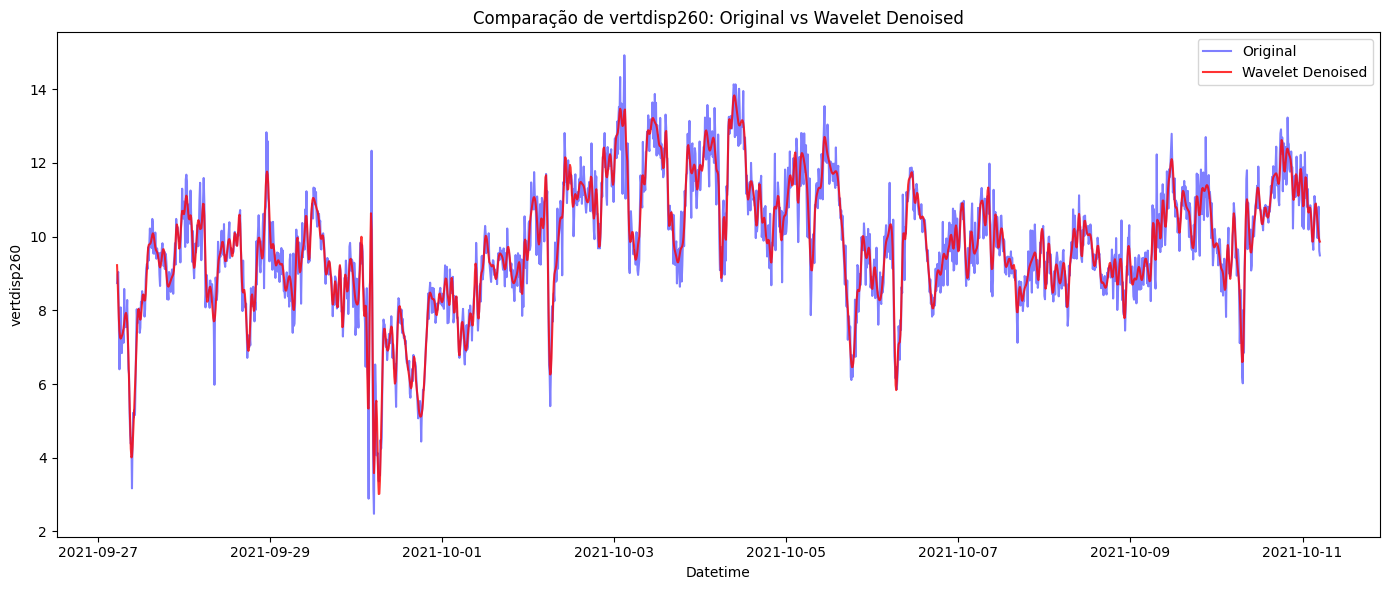

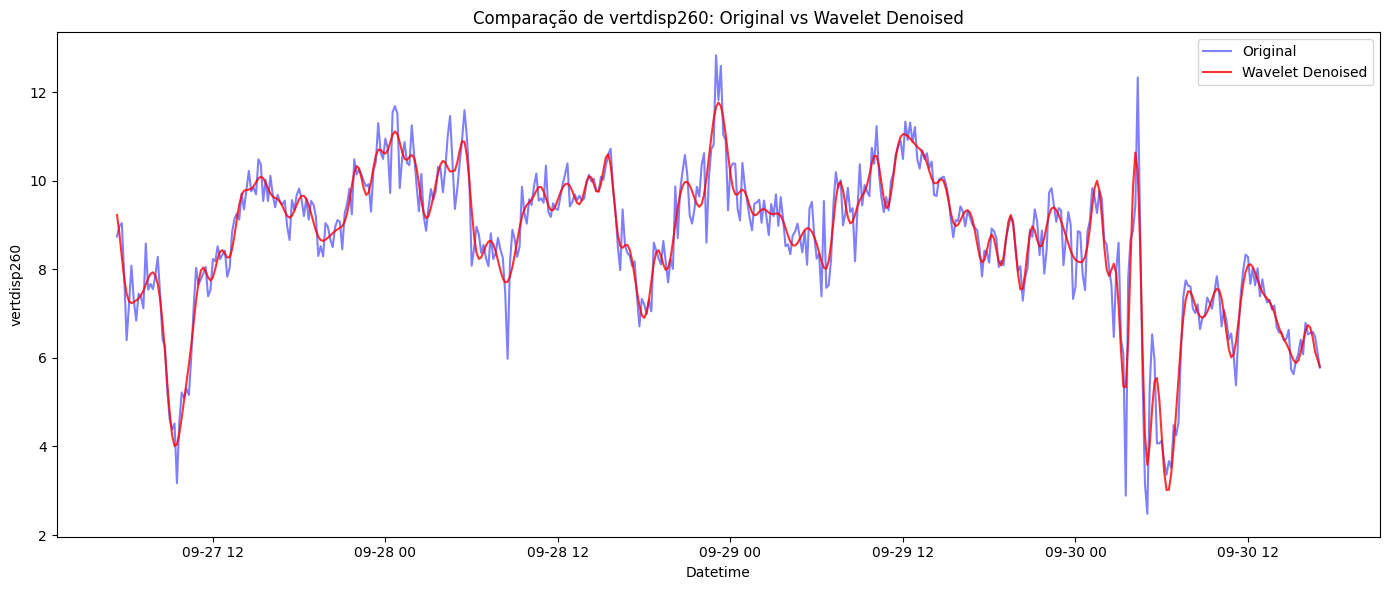

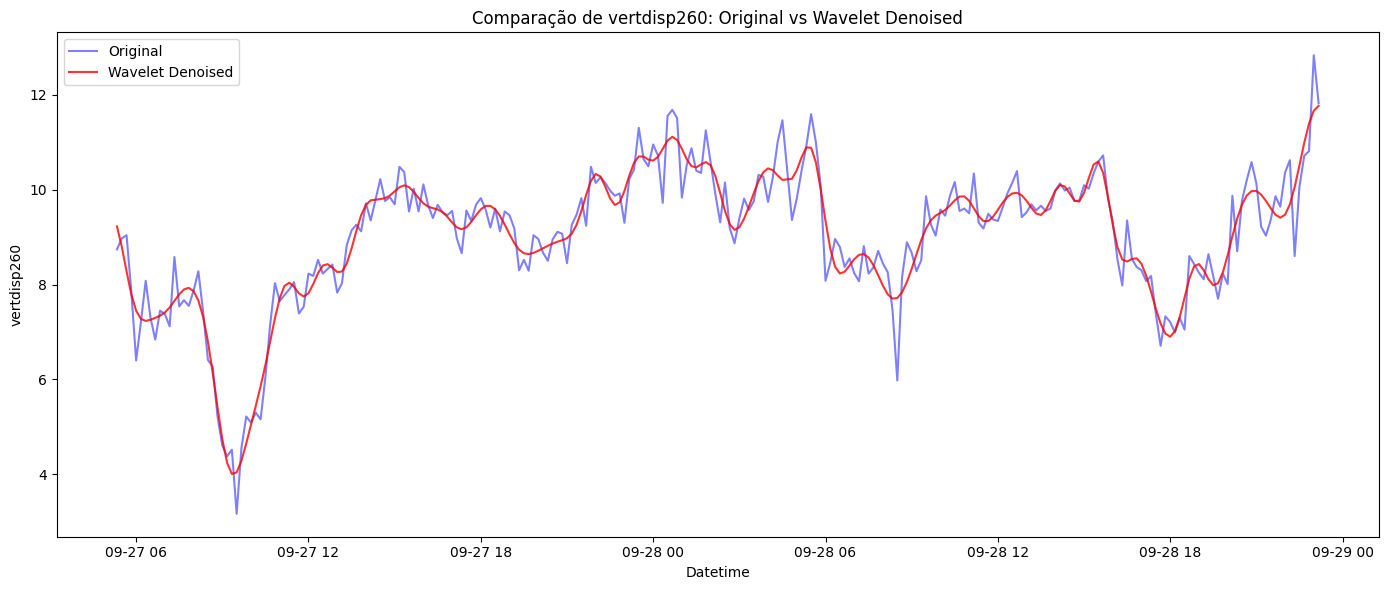

In [6]:
    
# Gráficos comparativo da curva original e denoised
plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:3500], data['ws100'][1500:3500], label='Original', alpha=0.5, color= 'blue')
plt.plot(variables.index[1500:3500], variables['ws100_wavelet'][1500:3500], label='Wavelet Denoised', alpha=0.8, color = 'red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:2000], data['ws100'][1500:2000], label='Original', alpha=0.5, color= 'blue')
plt.plot(variables.index[1500:2000], variables['ws100_wavelet'][1500:2000], label='Wavelet Denoised', alpha=0.8, color = 'red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:1750], data['ws100'][1500:1750], label='Original', alpha=0.5, color= 'blue')
plt.plot(variables.index[1500:1750], variables['ws100_wavelet'][1500:1750], label='Wavelet Denoised', alpha=0.8, color = 'red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# %%
# Após a criação das features de rolling
# Criação das features de rolling
def create_rolling_features(df, windows):
    rolled_columns = []  # Lista para armazenar as novas colunas
    for window_name, window_size in windows.items():
        for col in df.columns:
            rolled_column = df[col].rolling(window=window_size, min_periods=1).mean()
            rolled_columns.append(rolled_column.rename(f'{col}_rolling_mean_{window_name}'))
    
    # Concatenando todas as novas colunas em um DataFrame
    df_rolled = pd.concat(rolled_columns, axis=1)
    return df_rolled

windows = {
    'quarter': 36
}

# Gerando as features de rolling
rolling_features = create_rolling_features(variables, windows)

# Concatenando as novas features de rolling com o DataFrame original
variables = pd.concat([variables, rolling_features], axis=1)

# %%
# Adicionando a remoção das colunas 'ws' exceto 'ws100'

# Abordagem 1: Usando List Comprehension
columns_to_remove = [col for col in variables.columns if col.startswith('ws') and not col.startswith('ws100')]
variables = variables.drop(columns=columns_to_remove)
print(f"Colunas removidas: {columns_to_remove}")

# Opcional: Verificar as colunas restantes
print("Colunas restantes:")
print(variables.columns.tolist())

# %%
# Continuar com o restante do pipeline

variables['hour'] = variables.index.hour

variables['temp_humid_product'] = (
    variables['temp_wavelet'] * 
    variables['humid_wavelet']
)

variables.drop(columns=['temp_wavelet', 'humid_wavelet', 'hour'], inplace=True)

variables.head()


Colunas removidas: ['ws40_wavelet', 'ws50_wavelet', 'ws60_wavelet', 'ws70_wavelet', 'ws80_wavelet', 'ws90_wavelet', 'ws110_wavelet', 'ws120_wavelet', 'ws130_wavelet', 'ws140_wavelet', 'ws150_wavelet', 'ws160_wavelet', 'ws170_wavelet', 'ws180_wavelet', 'ws190_wavelet', 'ws200_wavelet', 'ws220_wavelet', 'ws240_wavelet', 'ws260_wavelet', 'ws40_wavelet_rolling_mean_quarter', 'ws50_wavelet_rolling_mean_quarter', 'ws60_wavelet_rolling_mean_quarter', 'ws70_wavelet_rolling_mean_quarter', 'ws80_wavelet_rolling_mean_quarter', 'ws90_wavelet_rolling_mean_quarter', 'ws110_wavelet_rolling_mean_quarter', 'ws120_wavelet_rolling_mean_quarter', 'ws130_wavelet_rolling_mean_quarter', 'ws140_wavelet_rolling_mean_quarter', 'ws150_wavelet_rolling_mean_quarter', 'ws160_wavelet_rolling_mean_quarter', 'ws170_wavelet_rolling_mean_quarter', 'ws180_wavelet_rolling_mean_quarter', 'ws190_wavelet_rolling_mean_quarter', 'ws200_wavelet_rolling_mean_quarter', 'ws220_wavelet_rolling_mean_quarter', 'ws240_wavelet_rolling_

,press_wavelet,temp_wavelet,ws100_wavelet,verts40_wavelet,verts50_wavelet,verts60_wavelet,verts70_wavelet,verts80_wavelet,verts90_wavelet,verts100_wavelet,...,vertdisp160_wavelet_rolling_mean_quarter,vertdisp170_wavelet_rolling_mean_quarter,vertdisp180_wavelet_rolling_mean_quarter,vertdisp190_wavelet_rolling_mean_quarter,vertdisp200_wavelet_rolling_mean_quarter,vertdisp220_wavelet_rolling_mean_quarter,vertdisp240_wavelet_rolling_mean_quarter,vertdisp260_wavelet_rolling_mean_quarter,hour,temp_humid_product
id_datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-16 18:00:00,1010.098974,28.188888,8.983404,-0.025422,-0.015838,0.009097,0.043236,0.072761,0.086112,0.103432,...,0.778679,0.784969,0.791508,0.807601,0.811118,0.806850,0.813989,0.817058,18,2068.009641
2021-09-16 18:10:00,1011.387441,27.757578,8.849366,-0.036791,-0.023397,0.004837,0.029459,0.056597,0.080189,0.107125,...,0.634896,0.644280,0.653868,0.671379,0.675712,0.675098,0.672752,0.677976,18,2130.053202
2021-09-16 18:19:59,1012.202525,27.350217,8.848879,-0.090180,-0.080431,-0.065605,-0.057187,-0.033685,-0.004589,0.024084,...,0.555281,0.564932,0.575825,0.593389,0.596877,0.595961,0.589133,0.593765,18,2154.722836
2021-09-16 18:30:00,1011.898789,27.535623,8.952212,-0.146302,-0.142203,-0.144479,-0.150602,-0.130105,-0.100646,-0.076022,...,0.524689,0.532663,0.543249,0.559749,0.561664,0.558322,0.550855,0.553929,18,2175.702217
2021-09-16 18:39:59,1011.960504,27.489673,9.060865,-0.162161,-0.158020,-0.164336,-0.176111,-0.156657,-0.128847,-0.107887,...,0.508425,0.514370,0.523699,0.538546,0.539307,0.533956,0.526958,0.529621,18,2185.082681


In [8]:
# %%
# Definir os grupos de features com base nos prefixos
import re

def get_feature_groups(columns):
    """
    Agrupa as colunas com base nos seus prefixos.

    Args:
        columns (list-like): Lista de nomes de colunas.

    Returns:
        dict: Dicionário onde as chaves são os grupos e os valores são listas de colunas pertencentes a cada grupo.
    """
    groups = {}
    for col in columns:
        # Extrair o prefixo antes do primeiro dígito ou caractere '_'
        match = re.match(r'^([a-zA-Z]+)', col)
        if match:
            prefix = match.group(1)
            if prefix not in groups:
                groups[prefix] = []
            groups[prefix].append(col)
    return groups

# Aplicar a função para obter os grupos
feature_groups = get_feature_groups(variables.columns.tolist())

# Exibir os grupos
print("Grupos de Features:")
for group, features in feature_groups.items():
    print(f"Grupo '{group}': {features}")

Grupos de Features:
Grupo 'press': ['press_wavelet', 'press_wavelet_rolling_mean_quarter']
Grupo 'temp': ['temp_wavelet', 'temp_wavelet_rolling_mean_quarter', 'temp_humid_product']
Grupo 'ws': ['ws100_wavelet', 'ws100_wavelet_rolling_mean_quarter']
Grupo 'verts': ['verts40_wavelet', 'verts50_wavelet', 'verts60_wavelet', 'verts70_wavelet', 'verts80_wavelet', 'verts90_wavelet', 'verts100_wavelet', 'verts110_wavelet', 'verts120_wavelet', 'verts130_wavelet', 'verts140_wavelet', 'verts150_wavelet', 'verts160_wavelet', 'verts170_wavelet', 'verts180_wavelet', 'verts190_wavelet', 'verts200_wavelet', 'verts220_wavelet', 'verts240_wavelet', 'verts260_wavelet', 'verts40_wavelet_rolling_mean_quarter', 'verts50_wavelet_rolling_mean_quarter', 'verts60_wavelet_rolling_mean_quarter', 'verts70_wavelet_rolling_mean_quarter', 'verts80_wavelet_rolling_mean_quarter', 'verts90_wavelet_rolling_mean_quarter', 'verts100_wavelet_rolling_mean_quarter', 'verts110_wavelet_rolling_mean_quarter', 'verts120_wavelet_r

In [10]:
# %%
# Seleção de uma feature por grupo baseada na correlação com a variável alvo

# Definir a variável alvo
target = 'ws100_wavelet'

# Inicializar lista para armazenar as features selecionadas
selected_features = []

# Iterar sobre cada grupo e selecionar a melhor feature
for group, features in feature_groups.items():
    # Ignorar a variável alvo se estiver presente em algum grupo
    if target in features:
        continue
    
    # Calcular a correlação de cada feature do grupo com a variável alvo
    correlations = variables[features].corrwith(variables[target]).abs()
    
    # Selecionar a feature com a maior correlação
    best_feature = correlations.idxmax()
    
    selected_features.append(best_feature)
    print(f"Grupo '{group}': Selecionada a feature '{best_feature}' com correlação {correlations.max():.4f}")

# Exibir as features selecionadas
print("\nFeatures selecionadas por grupo:")
print(selected_features)

# %%
# Atualizar o DataFrame para conter apenas as features selecionadas e a variável alvo
variables_selected = variables[selected_features + [target]]

# Verificar as primeiras linhas do DataFrame selecionado
print("\nPrimeiras linhas do DataFrame com as features selecionadas:")
print(variables_selected.head())

# %%
# Parâmetros para a criação das sequências
input_steps = 36  # Número de passos de entrada
output_steps = 36  # Número de passos de saída
target_col_index = variables_selected.columns.get_loc(target)

# Criar as sequências usando a função definida anteriormente
X_encoder, X_decoder, y_decoder = create_sequences(
    variables_selected.values, 
    input_steps, 
    output_steps, 
    target_col_index
)

print(f'X_encoder shape: {X_encoder.shape}')
print(f'X_decoder shape: {X_decoder.shape}')
print(f'y_decoder shape: {y_decoder.shape}')

# %%
# Definir as dimensões das features
num_encoder_features = X_encoder.shape[2]
num_decoder_features = X_decoder.shape[2]

# Construir o modelo Seq2Seq com Atenção
model = build_seq2seq_attention_model(
    input_steps=input_steps, 
    output_steps=output_steps, 
    num_encoder_features=num_encoder_features, 
    num_decoder_features=num_decoder_features
)

# Resumo do modelo
model.summary()

# Definir os callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

# Dividir os dados em treino e validação
from sklearn.model_selection import train_test_split

X_enc_train, X_enc_val, X_dec_train, X_dec_val, y_train, y_val = train_test_split(
    X_encoder, X_decoder, y_decoder, test_size=0.2, random_state=42
)

# Treinar o modelo
history = model.fit(
    [X_enc_train, X_dec_train], y_train,
    validation_data=([X_enc_val, X_dec_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Grupo 'press': Selecionada a feature 'press_wavelet_rolling_mean_quarter' com correlação 0.1692
Grupo 'temp': Selecionada a feature 'temp_humid_product' com correlação 0.5079
Grupo 'verts': Selecionada a feature 'verts40_wavelet_rolling_mean_quarter' com correlação 0.4000
Grupo 'wdir': Selecionada a feature 'wdir260_wavelet_rolling_mean_quarter' com correlação 0.3794
Grupo 'cis': Selecionada a feature 'cis1_wavelet_rolling_mean_quarter' com correlação 0.2147
Grupo 'wdisp': Selecionada a feature 'wdisp40_wavelet' com correlação 0.7420
Grupo 'vertdisp': Selecionada a feature 'vertdisp40_wavelet' com correlação 0.5315
Grupo 'humid': Selecionada a feature 'humid_wavelet_rolling_mean_quarter' com correlação 0.3196
Grupo 'hour': Selecionada a feature 'hour' com correlação 0.0293

Features selecionadas por grupo:
['press_wavelet_rolling_mean_quarter', 'temp_humid_product', 'verts40_wavelet_rolling_mean_quarter', 'wdir260_wavelet_rolling_mean_quarter', 'cis1_wavelet_rolling_mean_quarter', 'wdi

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 36, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_selection   │ (None, 36, 10)    │        110 │ encoder_inputs[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_enco… │ [(None, 36, 128), │     38,400 │ feature_selectio… │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 36, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 36, 128), │     66,560 │ decoder_inputs[0… │
│                     │ (None, 128),      │            │ concatenate_3[0]… │
│                     │ (None, 128)]      │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 36, 128)   │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 36, 128)   │          0 │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 36, 128)   │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 36, 256)   │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 36, 1)     │        257 │ concatenate_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,327 (411.43 KB)

 Trainable params: 105,327 (411.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1732534435.084892    7522 cuda_dnn.cc:529] Loaded cuDNN version 90300


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 27.9036 - mae: 4.2470 - val_loss: 3.2852 - val_mae: 1.3866 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 2.9883 - mae: 1.3374 - val_loss: 1.9056 - val_mae: 1.0506 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 1.5439 - mae: 0.9406 - val_loss: 0.7415 - val_mae: 0.6162 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.6879 - mae: 0.6058 - val_loss: 0.3980 - val_mae: 0.4385 - learning_rate: 0.0010
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.4258 - mae: 0.4741 - val_loss: 0.2718 - val_mae: 0.3533 - learning_rate: 0.0010
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.3189 - mae: 0.4073 - val_loss: 0.2011 - val_mae: 0.2945 - learning_rate: 0.0010
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.2631 - mae: 0.3692 - val_loss: 0.1621 - val_mae: 0.2583 - learning_rate: 0.0010
Epoch 8/100
94/9

In [ ]:

# Seleção de lags para cada variável usando AMI
lags_selected = {}
for col in variables.columns:
    signal = variables[col].dropna()
    minima, maxima, ami_values = select_lags_ami(signal, max_lag=288)
    print(f"Mínima: Lag selecionado usando AMI para {col}: {minima}")


Mínima: Lag selecionado usando AMI para press_wavelet: [29, 44, 46, 72, 95, 97, 116, 169, 193, 236, 263]
Mínima: Lag selecionado usando AMI para temp_wavelet: [31, 72, 110, 176, 214, 253]
Mínima: Lag selecionado usando AMI para ws40_wavelet: [33, 48, 52, 61, 64, 70, 82, 91, 94, 97, 99, 101, 107, 183, 186, 190, 192, 196, 199, 202, 210, 213, 216, 218, 223, 227, 231, 235, 240, 242, 250, 254, 264, 267, 273, 287]
Mínima: Lag selecionado usando AMI para ws50_wavelet: [41, 45, 48, 54, 59, 94, 97, 100, 107, 109, 177, 180, 185, 188, 196, 202, 208, 217, 227, 229, 231, 235, 237, 243, 246, 248, 250, 254, 265]
Mínima: Lag selecionado usando AMI para ws60_wavelet: [41, 43, 46, 52, 55, 94, 101, 104, 108, 111, 142, 163, 168, 178, 184, 190, 194, 201, 208, 212, 219, 226, 229, 231, 234, 244, 247, 252, 262, 264, 270, 273, 286]
Mínima: Lag selecionado usando AMI para ws70_wavelet: [41, 45, 47, 49, 94, 98, 101, 106, 111, 162, 176, 179, 181, 184, 192, 200, 204, 208, 211, 227, 231, 233, 237, 240, 242, 249, 25

In [ ]:

# Cálculo de ACF e PACF e plotagem
# for col in variables.columns:
#     signal = variables[col].dropna()
#     best_windows, acf_values = best_prediction_window(signal, max_lag=288)
#     pacf_values = pacf(signal, nlags=288, method='ols')  # Calculando PACF

#     print(f"A melhor janela de previsão para {col} com ACF são {best_windows + 1}.")

#     # Configurando os subplots para ACF e PACF
#     fig, axes = plt.subplots(2, 1, figsize=(12, 10))

#     # Plot do ACF
#     axes[0].stem(range(len(acf_values)), acf_values, linefmt='b-', markerfmt='bo', basefmt=" ", label='ACF')
#     axes[0].axhline(y=1 / np.e, color='red', linestyle='--', label='Limiar 1/e')

#     # Plotando todas as linhas verticais para cada crossing
#     for idx, window in enumerate(best_windows + 1):
#         if idx == 0:
#             axes[0].axvline(x=window, color='green', linestyle='--', label='Melhor Janela ACF')
#         else:
#             axes[0].axvline(x=window, color='green', linestyle='--')

#     axes[0].set_title(f'ACF de {col} até lag {288}')
#     axes[0].set_xlabel('Lag')
#     axes[0].set_ylabel('Autocorrelação')
#     axes[0].legend()

#     # Plot da PACF
#     axes[1].stem(range(len(pacf_values)), pacf_values, linefmt='orange', markerfmt='D', basefmt=" ", label='PACF')
#     axes[1].axhline(y=0, color='gray', linestyle='--')
#     axes[1].set_title(f'PACF de {col} até lag {288}')
#     axes[1].set_xlabel('Lag')
#     axes[1].set_ylabel('Autocorrelação Parcial')
#     axes[1].legend()

#     plt.tight_layout()
#     plt.show()

In [ ]:
# Histograma e KDE para cada variável
# for col in variables_engineered.columns:
#     plt.figure(figsize=(14, 6))
#     sns.histplot(variables_engineered[col], kde=True, bins=30, color='skyblue')
#     plt.title(f'Distribuição de {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequência')
#     plt.tight_layout()
#     plt.show()


In [ ]:
from statsmodels.tsa.stattools import ccf

# Correlação Cruzada entre 'ws100_wavelet' e outras variáveis
target_col = 'ws100_wavelet'
# for col in variables_engineered.columns:
#     if col != target_col:
#         correlation = ccf(variables_engineered[target_col], variables_engineered[col])[:288]  # Lag até 50
#         plt.figure(figsize=(14, 6))
#         plt.stem(range(len(correlation)), correlation)
#         plt.title(f'Correlação Cruzada entre {target_col} e {col}')
#         plt.xlabel('Lag')
#         plt.ylabel('Correlação Cruzada')
#         plt.tight_layout()
#         plt.show()
